In [1]:
# Cell 1: Imports & Path Fix for Jupyter Notebook

import sys
import os

# === Notebook-safe way to find project root ===
# Assuming the notebook is inside 'notebooks/' folder
notebook_dir = os.getcwd()  # current working directory when running the cell

# Go up one level if you're in notebooks/, or stay if already in root
if os.path.basename(notebook_dir) == 'notebooks':
    project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
else:
    project_root = notebook_dir  # already in root

# Add to sys.path if not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Project root added to sys.path:", project_root)

import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
from sklearn.decomposition import PCA
from src.dataset import load_data, compute_tfidf
from src.vae import train_vae
from src.clustering import perform_clustering, pca_baseline

# Import ALL metrics from evaluation.py
from src.evaluation import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    cluster_purity
)

Project root added to sys.path: g:\CSE-715-Project\VAE-for-Hybrid-Language-Music-Clustering


In [3]:
# Cell 2: Load & Preprocess Data
texts, artists = load_data('../data/lyrics')

features, vocab = compute_tfidf(texts, max_vocab=500)
print(f"Feature matrix shape: {features.shape}")

Loaded 49 artist lyrics from ../data/lyrics
Feature matrix shape: (49, 500)


In [4]:
# Cell 3: Train VAE & Extract Latent
latent_dim = 10
model = train_vae(features, hidden_dim=128, latent_dim=latent_dim, epochs=100, batch_size=16)

with torch.no_grad():
    mu, _ = model.encode(torch.from_numpy(features))
    latent = mu.numpy()

print(f"Latent representations shape: {latent.shape}")

Latent representations shape: (49, 10)


In [5]:
# Cell 4: Clustering (VAE + PCA baseline)
k = 5  # You can experiment with different k

vae_labels = perform_clustering(latent, k=k)
pca_labels, pca_features = pca_baseline(features, latent_dim, k=k)

print(f"VAE clusters: {np.unique(vae_labels, return_counts=True)}")
print(f"PCA clusters: {np.unique(pca_labels, return_counts=True)}")

VAE clusters: (array([0, 1, 2, 3, 4], dtype=int32), array([ 8, 15,  9,  2, 15]))
PCA clusters: (array([0, 1, 2, 3, 4], dtype=int32), array([14, 13,  9,  6,  7]))


In [6]:
# Cell 5: Evaluation - Unsupervised Metrics (no ground truth needed)
print("=== Unsupervised Metrics ===")
print("VAE Latent:")
print("  Silhouette:         ", silhouette_score(latent, vae_labels))
print("  Calinski-Harabasz:  ", calinski_harabasz_score(latent, vae_labels))
print("  Davies-Bouldin:     ", davies_bouldin_score(latent, vae_labels))

print("\nPCA Features:")
print("  Silhouette:         ", silhouette_score(pca_features, pca_labels))
print("  Calinski-Harabasz:  ", calinski_harabasz_score(pca_features, pca_labels))
print("  Davies-Bouldin:     ", davies_bouldin_score(pca_features, pca_labels))

=== Unsupervised Metrics ===
VAE Latent:
  Silhouette:          0.16626343103921593
  Calinski-Harabasz:   10.75137
  Davies-Bouldin:      1.4604033123609765

PCA Features:
  Silhouette:          0.25974124366873685
  Calinski-Harabasz:   16.87961
  Davies-Bouldin:      1.2084294784863063


In [ ]:
# Cell 6: Evaluation - Supervised Metrics (only if you have ground truth labels)
# Example: if you manually assign true labels (0=rap, 1=pop, 2=rock, etc.)
# true_labels = np.array([...])  # length == len(artists)

# Uncomment and fill if you have true labels:
# print("\n=== Supervised Metrics (VAE) ===")
# print("ARI:   ", adjusted_rand_score(true_labels, vae_labels))
# print("NMI:   ", normalized_mutual_info_score(true_labels, vae_labels))
# print("Purity:", cluster_purity(true_labels, vae_labels))

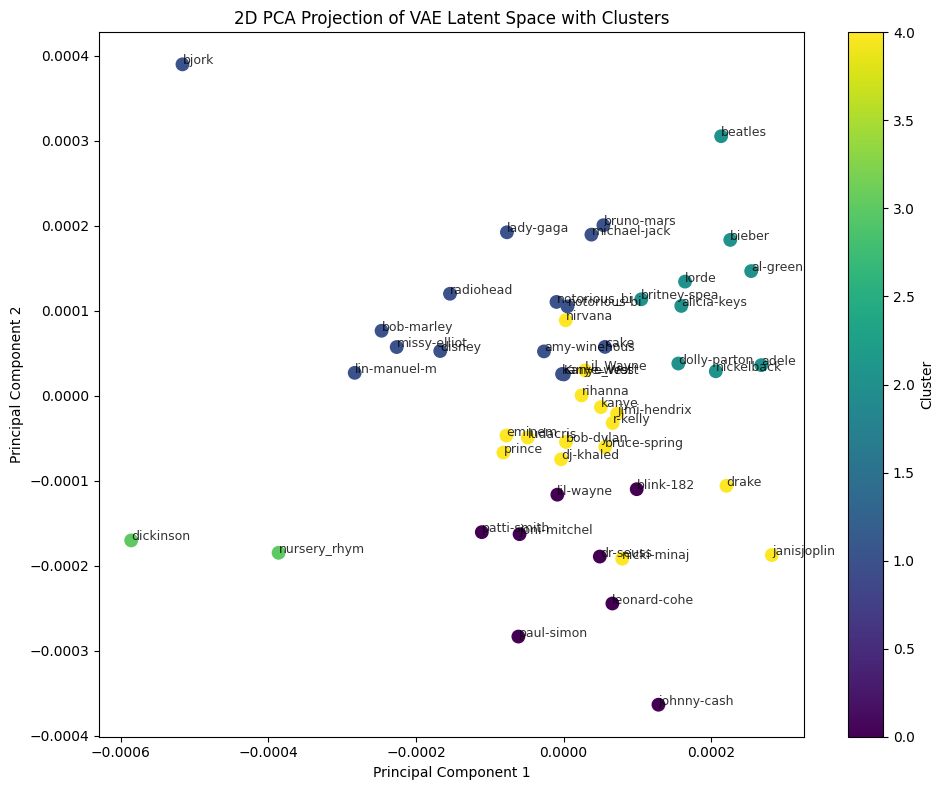

Results saved to 'results/' folder


In [7]:
# Cell 7: Visualization & Save Results
os.makedirs('results/latent_visualization', exist_ok=True)

pca_2d = PCA(n_components=2)
latent_2d = pca_2d.fit_transform(latent)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=vae_labels, cmap='viridis', s=80)
plt.colorbar(scatter, label='Cluster')
for i, artist in enumerate(artists):
    plt.annotate(artist[:12], (latent_2d[i, 0], latent_2d[i, 1]), fontsize=9, alpha=0.8)
plt.title('2D PCA Projection of VAE Latent Space with Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.savefig('results/latent_visualization/vae_latent_clusters.png', dpi=300)
plt.show()

# Optional: Save metrics to CSV
metrics = {
    'Method': ['VAE', 'PCA'],
    'Silhouette': [silhouette_score(latent, vae_labels), silhouette_score(pca_features, pca_labels)],
    'Calinski-Harabasz': [calinski_harabasz_score(latent, vae_labels), calinski_harabasz_score(pca_features, pca_labels)],
    'Davies-Bouldin': [davies_bouldin_score(latent, vae_labels), davies_bouldin_score(pca_features, pca_labels)]
}
pd.DataFrame(metrics).to_csv('results/clustering_metrics.csv', index=False)
print("Results saved to 'results/' folder")